In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../DATA/gene_expression.csv')
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


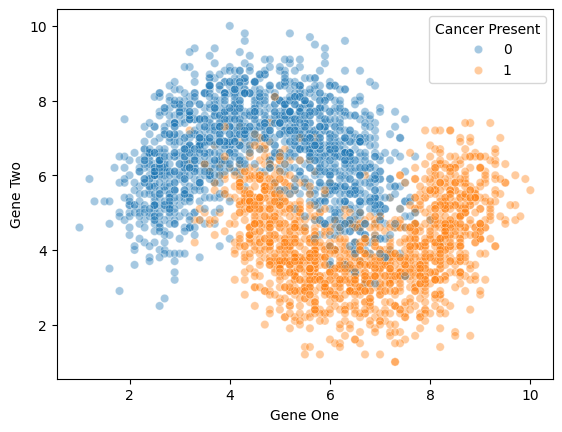

In [ ]:
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.4);

In [7]:
len(df)

3000

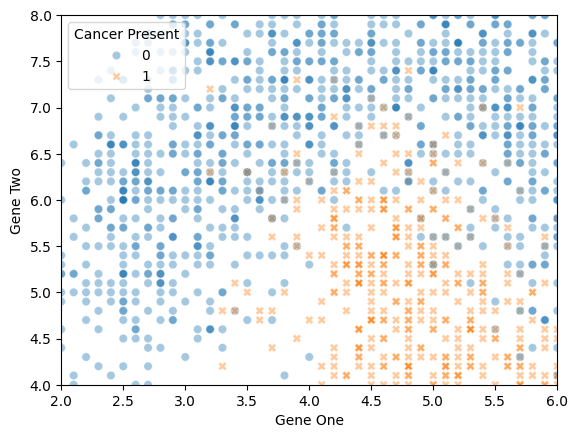

In [13]:
plt.figure(dpi=100)
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.4, style='Cancer Present')
plt.xlim(2,6)
plt.ylim(4,8);

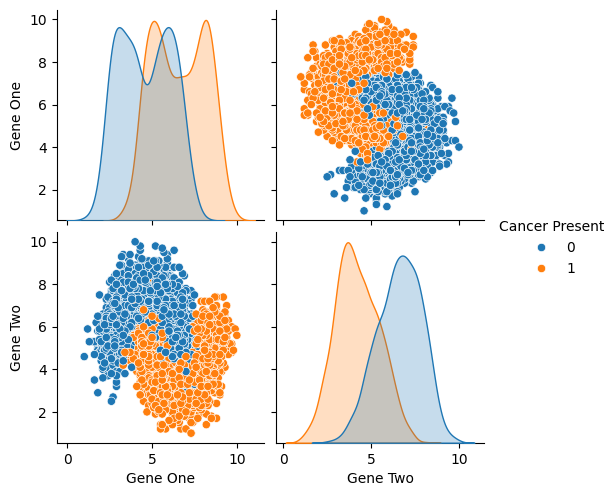

In [16]:
sns.pairplot(data=df, hue='Cancer Present');

,Gene One,Gene Two
0,-0.711200,-0.873712
1,-1.695839,0.514540
2,0.054629,-0.873712
3,0.273438,0.456696
4,0.984565,-1.162931
...,...,...
2995,-0.328286,0.630228
2996,-1.203520,0.688072
2997,-1.586434,0.630228
2998,-1.258222,0.109633


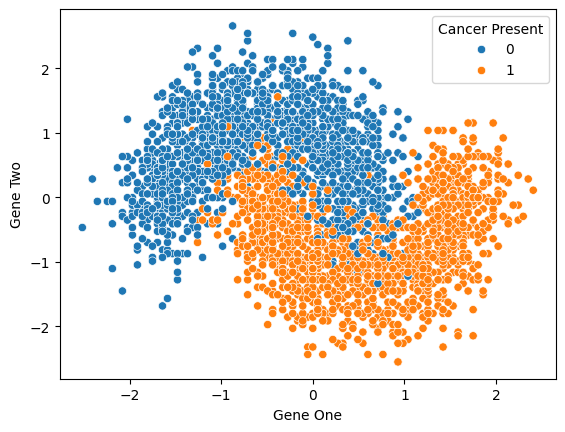

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=['Gene One','Gene Two'])

X_scaled
sns.scatterplot(data=X_scaled, x='Gene One', y='Gene Two', hue=y)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(conf_matrix)
print(class_report)

[[445  25]
 [ 27 403]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       470
           1       0.94      0.94      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [25]:
len(y_test)

900

In [27]:
df['Cancer Present'].value_counts() # равное распределение

Cancer Present
1    1500
0    1500
Name: count, dtype: int64

---
#### Метод Локтя.

error = 1 - accuracy

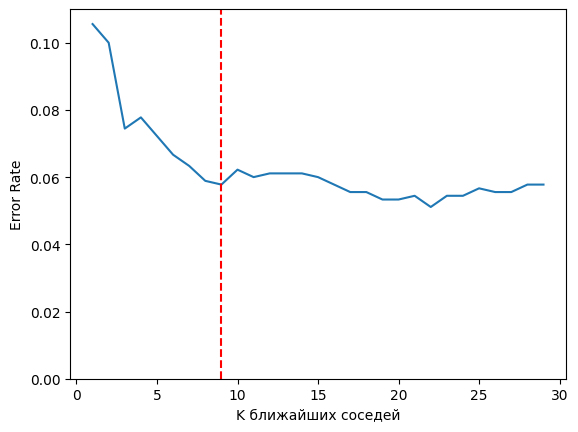

In [50]:
from sklearn.metrics import accuracy_score

test_error_rates = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    
    y_pred = knn_model.predict(X_test_scaled)
    
    error = 1 - accuracy_score(y_test, y_pred)
    
    test_error_rates.append(error)


plt.plot(range(1,30), test_error_rates)
plt.ylabel('Error Rate')
plt.xlabel('K ближайших соседей')
plt.ylim(0,0.11)
plt.axvline(x=9, color='red', linestyle='--');

---
#### Cross-Validation & Pipeline

In [51]:
scaler = StandardScaler()

In [52]:
knn = KNeighborsClassifier()

In [53]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [54]:
operations = [('scaler',scaler), ('knn',knn)]

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline(operations)

k_values = list(range(1,30))
print(k_values)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [57]:
# param_grid = {'n_neighbors': k_values} - не работает с Pipeline

In [59]:
param_grid = {'knn__n_neighbors': k_values}

In [60]:
# маштабирование внутри Pipeline

full_cs_classifier = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy')
full_cs_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [62]:
full_cs_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=20))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=20),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 20,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [66]:
y_pred = full_cs_classifier.predict(X_test) # маштабирование внутри Pipeline
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900

[[451  19]
 [ 29 401]]


In [69]:
new_patient = [[3.8, 6.4]]
print(full_cs_classifier.predict(new_patient))
print(full_cs_classifier.predict_proba(new_patient))

[0]
[[0.9 0.1]]


/Users/user/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/user/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
